
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example
In this notebook you perfrom QE and iterative lensing reconstruction for one simulation, and on the full sky.
The simulations are created upon runtime inclusive of isotropic white noise, using a generic CMB `sims` module, and include postborn effect.
At the end, we will plot the lensing potential estimate of both, the QE and iterative lensing reconstruction.

The configuration file is [here](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_GF.py), and you can freely change the parameters to your liking.

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# QE lensing reconstruction
The following cell 
 
 * line 1: selects the [configuration file](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_GF.py) ,
 * line 2: initialises dlensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: and runs lensing reconstruction.


When run for the first time, it will also generate the CMB simulations and store them at `'lib_dir': opj(os.environ['CSCRATCH'], 'generic','nlevp1.00')` (check out the configuration file). If this path is not convenient for you, please choose one that works for you.

In [2]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_GF.py')
# fn = '/pscratch/sd/s/sebibel/dlensalot/n32/sims_postborn/sims_postborn_lminB200_postborn_GF/conf_mwe_GF.py'
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_GF.py
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/n32/sims_postborn/sims_postborn_lminB30_postborn_GF_Louissettings/conf_mwe_GF.py
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-01 14:53:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-01 14:53:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-01 14:53:: lenscarf.lerepi.core.handler.log -

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case.
For the iterations, we use a fast Wiener-filtering, allowing us to get fast iterative results in an idealized setting.

(We could have skipped above cell entirely. As iterative lensing reconstruction depends on a QE starting point, Dlensalot would have known to run `QE_lensrec` first.)

In [2]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_GF.py')
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=False).job
ana_mwe.run()

# Check your results
## lensing potential
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [3]:
ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)

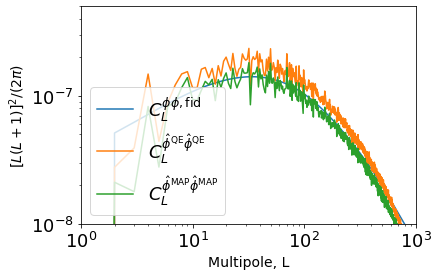

In [34]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [15])[0]

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')
# plt.plot(scale_factor*hp.alm2cl(plm_MAP[1]), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18)
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-8,5e-7)
plt.yscale('log')

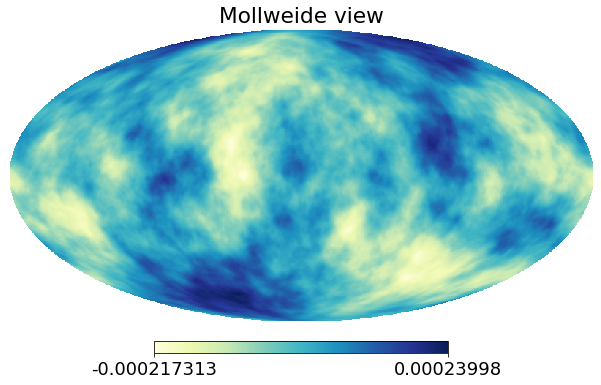

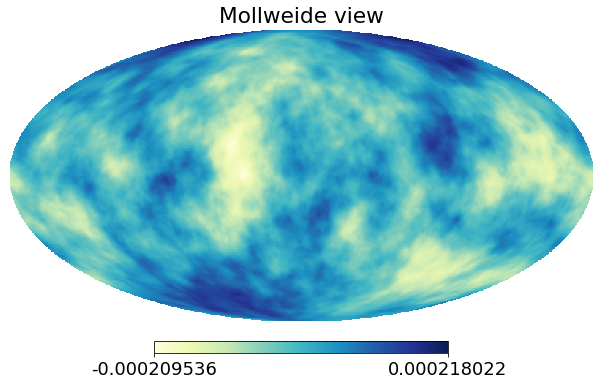

In [35]:
hp.mollview(hp.alm2map(plm_QE, nside=2048), cmap='YlGnBu')
hp.mollview(hp.alm2map(plm_MAP, nside=2048), cmap='YlGnBu')

# Delensed spectrum

In [30]:
input_blensing = ana_mwe._sims.get_sim_blm(0)
iblens_map = hp.alm2map(ph.bandpass_alms(input_blensing,0,200), nside=1024)

blt_QE = ana_mwe.get_blt_it(0, 0, calc=False)
blt_QE_map = hp.alm2map(ph.bandpass_alms(blt_QE,0,200), nside=1024)

blt_MAP = ana_mwe.get_blt_it(0, 19, calc=False)
blt_MAP_map = hp.alm2map(ph.bandpass_alms(blt_MAP,0,200), nside=1024)

/global/u2/s/sebibel/git/lenscarf/lenscarf/core/handler.py:687: RuntimeWarning: invalid value encountered in true_divide
  np.save(fn, mf/self.Nmf)


Text(0, 0.5, '$C_\\ell$ [$\\mu \\rm{K}^2$]')

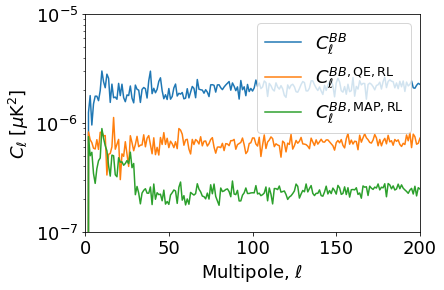

In [32]:
plt.plot(hp.anafast(iblens_map,lmax=200), label=r'$C_\ell^{BB}$')
plt.plot(hp.anafast(iblens_map - blt_QE_map,lmax=200), label=r'$C_\ell^{BB,{\rm QE,RL}}$')
plt.plot(hp.anafast(iblens_map - blt_MAP_map,lmax=200), label=r'$C_\ell^{BB,{\rm MAP,RL}}$')

plt.legend()
plt.yscale('log')
plt.xlim(0,200)
plt.ylim(1e-7,1e-5)
plt.xlabel('Multipole, $\ell$')
plt.ylabel(r'$C_\ell$ [$\mu \rm{K}^2$]')